In [1]:
import os
from google.colab import files
import pandas as pd
import cv2

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
pip install Augmentor

In [4]:
import Augmentor

In [5]:
p = Augmentor.Pipeline("Path to the training dataset", output_directory = "path to the augmented dataset")


Initialised with 3200 image(s) found.
Output directory set to /content/gdrive/MyDrive/Output.

In [6]:
p.rotate(probability = 0.7, max_left_rotation = 10, max_right_rotation = 10)

In [7]:
p.zoom(probability = 0.3, min_factor = 1.1, max_factor = 1.6)

In [8]:
p.sample(6000)

Processing <PIL.Image.Image image mode=RGB size=239x279 at 0x7C1A4A637190>: 100%|██████████| 6000/6000 [00:45<00:00, 131.05 Samples/s]


In [9]:
import pathlib
import tensorflow as tf

data_dir = pathlib.Path("path to the Augmented dataset")
img_width = 224
img_height = 224

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_width, img_height),
  batch_size=32)

Found 6000 files belonging to 2 classes.
Using 4800 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_width, img_height),
  batch_size=32)

Found 6000 files belonging to 2 classes.
Using 1200 files for validation.


In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [15]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.97878593


In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D, concatenate
from tensorflow.keras.layers import Input, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model



def inception_module_1(x):

  conv_1x1 = layers.Conv2D(64, kernel_size = (1, 1), strides=(1, 1), dilation_rate=(1, 1), activation = 'relu')(x)

  conv_1x1_2 = layers.Conv2D(64, kernel_size = (1, 1), strides=(1, 1), dilation_rate=(1, 1), activation = 'relu')(x)
  conv_1x1_2 = layers.Conv2D(64, kernel_size = (3, 3), strides=(1, 1), dilation_rate=(1, 1), activation = 'relu')(conv_1x1_2)

  conv_1x1_3 = layers.Conv2D(64, kernel_size = (1, 1), strides=(1, 1), dilation_rate=(1, 1), activation = 'relu')(x)
  conv_1x1_3 = layers.Conv2D(64, kernel_size = (5, 5), strides=(1, 1), dilation_rate=(1, 1), activation = 'relu')(conv_1x1_3)

  conv_1x1_4 = layers.Conv2D(64, kernel_size = (1, 1), strides=(1, 1), dilation_rate=(1, 1), activation = 'relu')(x)
  conv_1x1_4 = layers.Conv2D(64, kernel_size = (7, 7), strides=(1, 1), dilation_rate=(1, 1), activation = 'relu')(conv_1x1_4)

  maxPool_2x2 = layers.MaxPooling2D((2, 2), strides=(1, 1))(x)

  conv_1x1 = layers.Resizing(224,224)(conv_1x1)
  conv_1x1_2 = layers.Resizing(224,224)(conv_1x1_2)
  conv_1x1_3 = layers.Resizing(224,224)(conv_1x1_3)
  conv_1x1_4 = layers.Resizing(224,224)(conv_1x1_4)
  maxPool_2x2 = layers.Resizing(224,224)(maxPool_2x2)

  inceptionModule_1 = layers.Concatenate()([conv_1x1, conv_1x1_2, conv_1x1_3, conv_1x1_4, maxPool_2x2])

  return inceptionModule_1


def inception_module_2(x):
  conv_3x3 = Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(x)
  conv_5x5 = Conv2D(64, kernel_size = (5, 5), strides = (1, 1), activation = 'relu')(x)
  conv_7x7 = Conv2D(64, kernel_size = (7, 7), strides = (1, 1), activation = 'relu')(x)
  maxPool_2x2 = layers.MaxPooling2D((2, 2), strides=(1, 1))(x)

  conv_3x3 = layers.Resizing(224,224)(conv_3x3)
  conv_5x5 = layers.Resizing(224,224)(conv_5x5)
  conv_7x7 = layers.Resizing(224,224)(conv_7x7)
  maxPool_2x2 = layers.Resizing(224,224)(maxPool_2x2)


  inceptionModule_2 = layers.concatenate([conv_3x3, conv_5x5, conv_7x7, maxPool_2x2])

  return inceptionModule_2

def inception_module_3(x):
  conv_9x9 = layers.Conv2D(64, kernel_size = (9, 9), strides = (2, 2), activation = 'relu')(x)
  conv_13x13 = layers.Conv2D(64, kernel_size = (13, 13), strides = (2, 2), activation = 'relu')(x)
  conv_15x15 = layers.Conv2D(64, kernel_size = (15, 15), strides = (2, 2), activation = 'relu')(x)
  maxPool_2x2 = layers.MaxPooling2D((2, 2), strides=(1, 1))(x)

  conv_9x9 = layers.Resizing(224,224)(conv_9x9)
  conv_13x13 = layers.Resizing(224,224)(conv_13x13)
  conv_15x15 = layers.Resizing(224,224)(conv_15x15)
  maxPool_2x2 = layers.Resizing(224,224)(maxPool_2x2)

  inceptionModule_3 = layers.concatenate([conv_9x9, conv_13x13, conv_15x15, maxPool_2x2])

  return inceptionModule_3

def build_vgg19():
  input_tensor = tf.keras.Input(shape=(224, 224, 3))

  #BLOCK - 1
  x = layers.Conv2D(64, (3, 3), strides = (1, 1), activation='relu', padding='same')(input_tensor)
  x = layers.Conv2D(64, (3, 3), strides = (1, 1), activation='relu', padding='same')(x)
  #Inception Module 1
  inception_Module_1 = inception_module_1(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(inception_Module_1)
  #x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


  #BLOCK - 2
  x = layers.Conv2D(128, (3, 3), strides = (1, 1), activation='relu', padding='same')(x)
  x = layers.Conv2D(128, (3, 3), strides = (1, 1), activation='relu', padding='same')(x)
  #Inception_module_2
  inception_Module_2 = inception_module_2(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(inception_Module_2)
  #x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

  #BLOCK - 3
  x = layers.Conv2D(256, (3, 3), strides = (1, 1), activation='relu', padding='same')(x)
  x = layers.Conv2D(256, (3, 3), strides = (1, 1), activation='relu', padding='same')(x)
  #Inception_module_3
  inception_Module_3 = inception_module_3(x)
  x = layers.Conv2D(256, (3, 3), strides = (1, 1), activation='relu', padding='same')(inception_Module_3)
  #x = layers.Conv2D(256, (3, 3), strides = (1, 1), activation='relu', padding='same')(x)
  x = layers.Conv2D(256, (3, 3), strides = (1, 1), activation='relu', padding='same')(x)
  x = layers.Conv2D(256, (3, 3), strides = (1, 1), activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

  #BLOCK - 4
  x = layers.Conv2D(512, (3, 3), strides = (1, 1), activation='relu', padding='same')(x)
  x = layers.Conv2D(512, (3, 3), strides = (1, 1), activation='relu', padding='same')(x)
  x = layers.Conv2D(512, (3, 3), strides = (1, 1), activation='relu', padding='same')(x)
  x = layers.Conv2D(512, (3, 3), strides = (1, 1), activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

  #BLOCK - 5
  x = layers.Conv2D(512, (3, 3), strides = (1, 1), activation='relu', padding='same')(x)
  x = layers.Conv2D(512, (3, 3), strides = (1, 1), activation='relu', padding='same')(x)
  x = layers.Conv2D(512, (3, 3), strides = (1, 1), activation='relu', padding='same')(x)
  x = layers.Conv2D(512, (3, 3), strides = (1, 1), activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

  #Flatten and Fully Connected Layer
  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dense(1024, activation='relu')(x)
  #x = layers.Dropout(0.5)(x)
  x = layers.Dense(2, activation='softmax')(x)

  model = tf.keras.Model(inputs = input_tensor, outputs = x)
  return model


In [27]:
# Create the VGG-19 model
vgg19_model = build_vgg19()

# Compile the model
vgg19_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(vgg19_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 224, 224, 64)         1792      ['input_6[0][0]']             
                                                                                                  
 conv2d_31 (Conv2D)          (None, 224, 224, 64)         36928     ['conv2d_30[0][0]']           
                                                                                                  
 conv2d_33 (Conv2D)          (None, 224, 224, 64)         4160      ['conv2d_31[0][0]']           
                                                                                            

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath = "path to save your model"
checkpoint = ModelCheckpoint(
    filepath = model_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)

In [29]:
history1 = vgg19_model.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks = [checkpoint])

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.7110
Epoch 1: val_accuracy improved from -inf to 0.74083, saving model to /content/gdrive/MyDrive/model-01-0.7408.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 246s 1s/step - loss: 0.6939 - accuracy: 0.7110 - val_loss: 0.5925 - val_accuracy: 0.7408
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 0.5398 - accuracy: 0.7113
Epoch 2: val_accuracy improved from 0.74083 to 0.74250, saving model to /content/gdrive/MyDrive/model-02-0.7425.hdf5
150/150 [==============================] - 144s 961ms/step - loss: 0.5398 - accuracy: 0.7113 - val_loss: 0.4890 - val_accuracy: 0.7425
Epoch 3/20
150/150 [==============================] - ETA: 0s - loss: 0.5151 - accuracy: 0.7098
Epoch 3: val_accuracy did not improve from 0.74250
150/150 [==============================] - 130s 869ms/step - loss: 0.5151 - accuracy: 0.7098 - val_loss: 0.4807 - val_accuracy: 0.7425
Epoch 4/20
150/150 [==============================] - ETA: 0s - loss: 0.5060 - accuracy: 0.7127
Epoch 4: val_accuracy improved from 0.74250 to 0.75417, saving model to /content/gdrive/MyDrive/model-04-0.7542.hdf5
150/150 [================

In [30]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Accuracy')

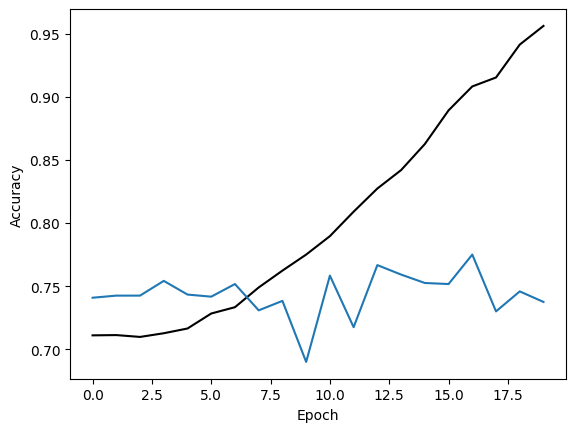

In [31]:
plt.plot(history1.history['accuracy'], label='accuracy', color = 'black')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

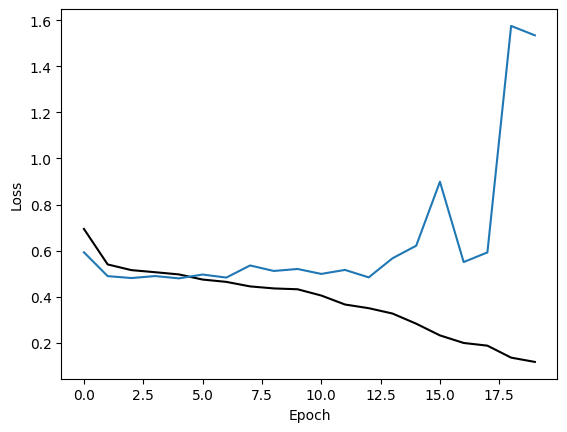

In [33]:
plt.plot(history1.history['loss'], label='loss', color = 'black')
plt.plot(history1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
test_data_dir = pathlib.Path("path to the testing dataset")
img_width = 224
img_height = 224

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_width, img_height),
  batch_size=32)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

In [ ]:
#load the best saved model
model = "path to best saved model."
predictions = model.predict(test_ds)
test_pred_classes = (predictions > 0.5).astype(np.int)

In [ ]:
import os
import pandas as pd

# Path to the folder containing the images
folder_path = 'path to the test dataset folder'

# Get a list of all files in the folder
file_names = os.listdir(folder_path)

# Filter out non-image files (if needed)
image_files = [file_name for file_name in file_names if file_name.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Create a DataFrame with the image names
df = pd.DataFrame({'Image Name': image_files, 'Predicted class label': y_pred_classes})

print(df)

df.to_excel('output.xlsx', index=False)